<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/thoracic_oar_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Tutorial

The purpose of this tutorial is to educate users on: 

* how to select, access, and download cohorts from IDC;
* what are some of the tools that can be used to get the DICOM data ready for your favourite imaging analysis pipelines;
* how to run an end-to-end pipeline and visualise the final results exploiting the Google Cloud Computing (GCP) and IDC platform.

**To access the resources needed for this tutorial, you will need to be registered on the IDC platform.**

If you are not yet registered, [sign up at this link](https://portal.imaging.datacommons.cancer.gov/accounts/signup/) or simply make sure you can [sign in at the IDC portal via your Google account](https://portal.imaging.datacommons.cancer.gov/accounts/login/)




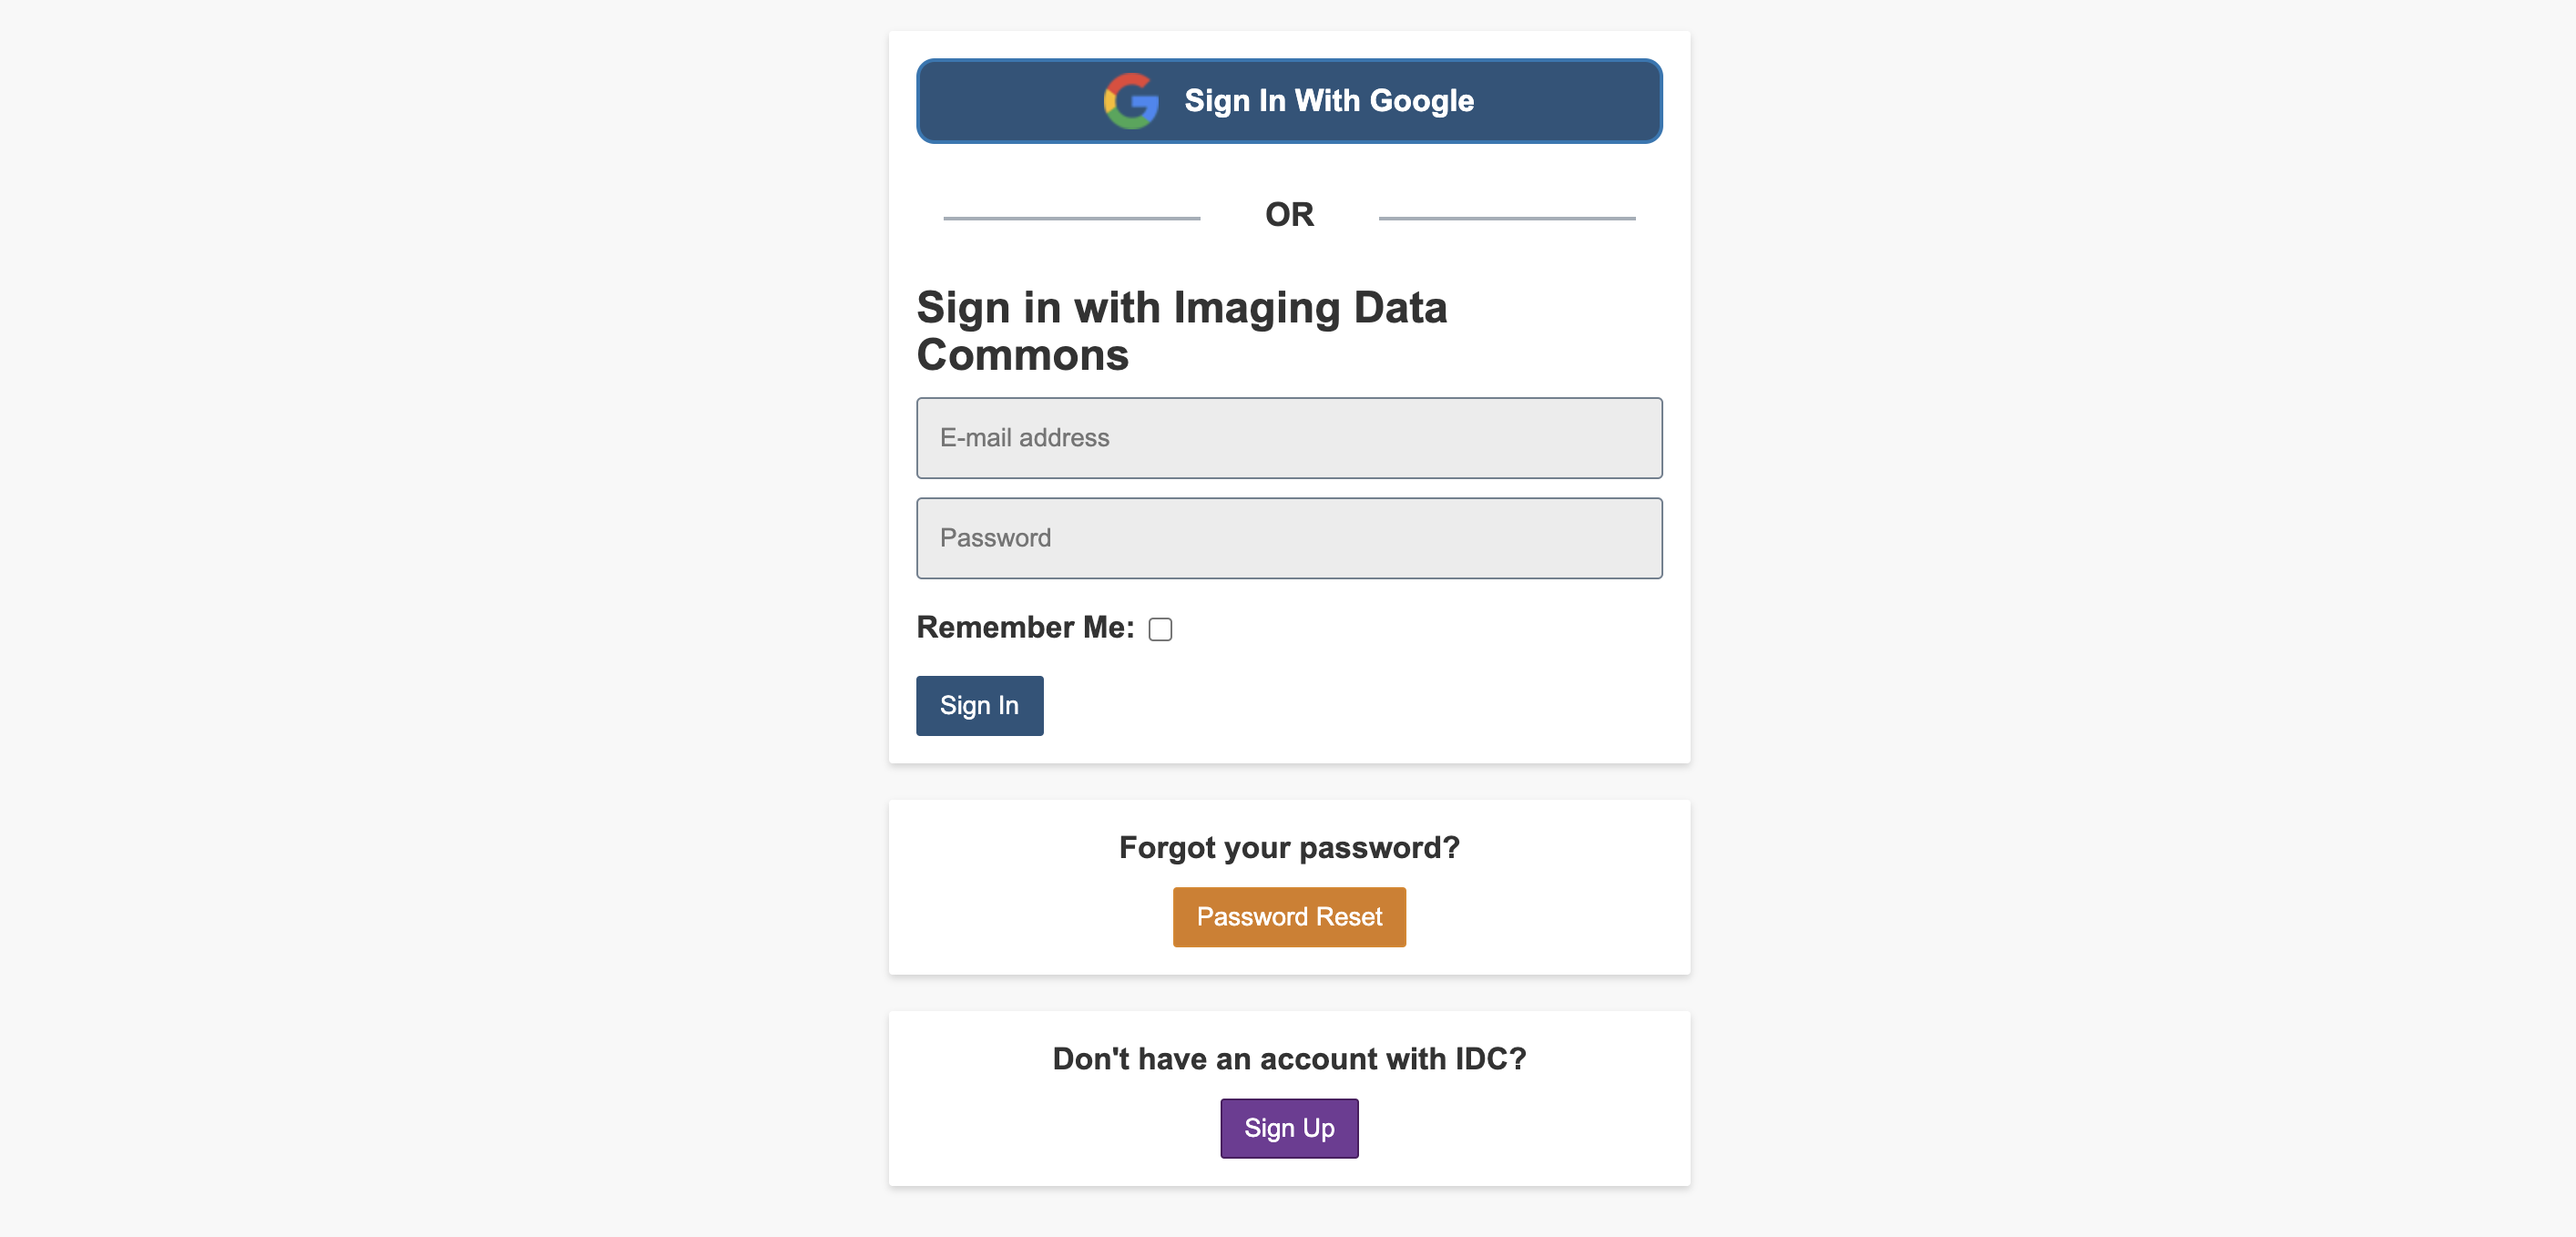

<br>

**To speed up the AI Image Processing pipelines, make sure the Colab Instance you are using is equipped with a GPU.**

You can check by clicking on "Runtime" in the menu bar, then selecting "Change Runtime Type" and making sure "GPU" is selected as Hardware acceleration. Colab GPUs include Nvidia K80s, T4s, P4s and P100s. As there is no way to choose what type of GPU you can connect to in Colab at any given time, processing times may vary.

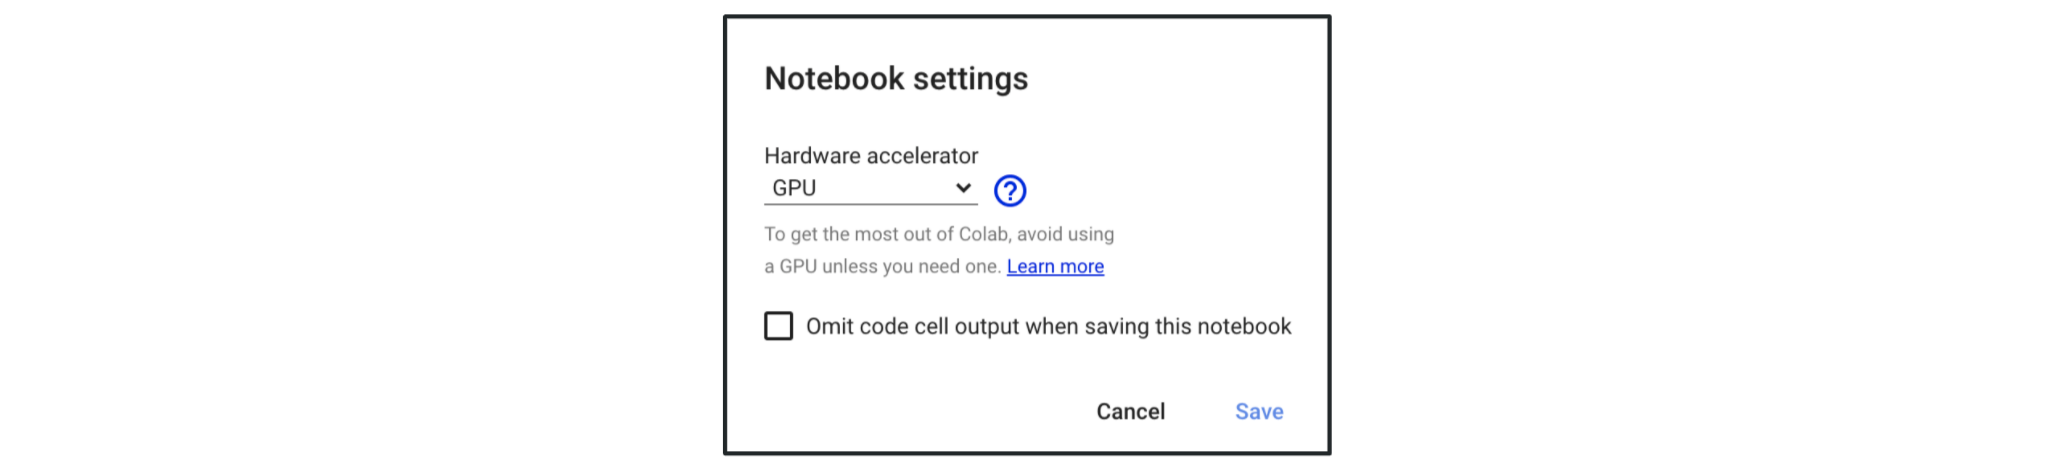

---

<br>

**In this notebook, we will test and end-to-end AI pipeline for thoracic organs at risk (OAR) segmentation from chest CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.**

The AI pipeline exploits one of the pre-trained models shared as part of the [nn-Unet model collection](https://www.nature.com/articles/s41592-020-01008-z). This model was trained on the [_SegTHOR: segmentation of thoracic organs at risk in CT images_](https://competitions.codalab.org/competitions/21145) dataset to segment the heart, the aorta, the esophagus, and the trachea from chest CT scans.

<br>

**As mentioned above, the AI model deployed in this notebook has been trained on external and completely independent datasets from the IDC cohorts we are about to test them on.**

The idea behind this tutorial is therefore not to showcase a perfect AI-based processing pipeline, but rather investigate how IDC can help promoting transparency, reusability and reproducibility in AI - potentially accelerating the translation of these methods into clinical settings.


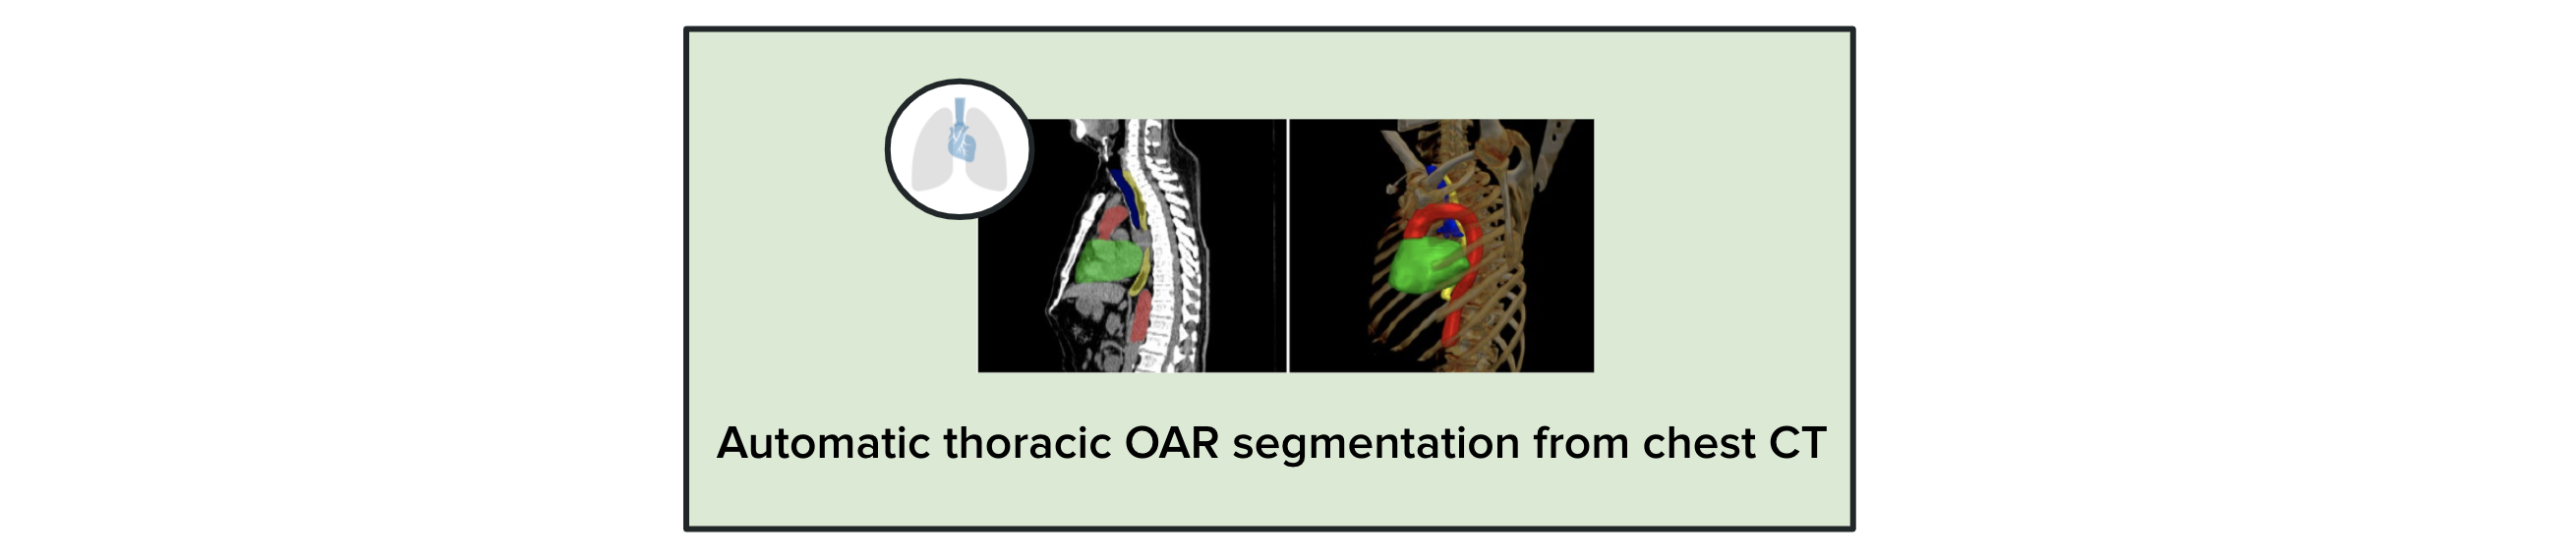

---

<br>

Since this demonstration runs in Google Colab, it highlights only a small part of what IDC can offer in terms of computational capability and imaging analysis: a more comprehensive experience of such tools can be explored, e.g., by experimenting with GCP Virtual Machines.

To learn more about how to access the GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

<br>

**Any questions, bugs to report, or features you would like to see implemented in IDC?**

You are welcome to get in touch with us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


---

# Init & Imports

In order to access the IDC resources, the user must complete at first the Google authentication process.

To continue with the notebook, when prompted by the next code cell follow the generated link. After granting Google Cloud SDK access to the selected Google account, you will get a one-use login code. Copy the code, paste it in the blank space under the cell, and press enter to complete the authentication procedure.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : 577b29821f6c
Username          : root


Before continuing with the notebook, we need to set-up the Google Colab environment by installing the Python and system dependencies the pre-processing and processing pipeline rely on.

## Python Dependencies

Install and import all the Python dependencies. 

The main python packages we need to install are:
* `nnunet` - which is the [codebase for the nn-UNet framework](https://github.com/MIC-DKFZ/nnUNet) we are going to be using for the segmentation step;
* `pydicom`, a Python [package](https://github.com/pydicom/pydicom) that lets the use read, modify, and write DICOM data in an easy "pythonic" way - that we are going to use to distinguish different DICOM objects from each other.

In [ ]:
%%capture
!pip install nnunet
!pip install pydicom

In [ ]:
# check wether the Colab Instance was correctly changed to a GPU instance
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

In [ ]:
import os
import sys
import shutil

import time
import gdown

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import nibabel as nib
import SimpleITK as sitk

from medpy.metric.binary import dc as dice_coef
from medpy.filter.binary import largest_connected_component

# use the "tensorflow_version" magic to make sure TF 1.x is imported
%tensorflow_version 1.x
import tensorflow as tf
import keras

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)
print("TensorFlow version           : ", tf.__version__)
print("Keras (stand-alone) version  : ", keras.__version__)

print("\nThis Colab instance is equipped with a GPU.")

# ----------------------------------------

#everything that has to do with plotting goes here below
import matplotlib
matplotlib.use("agg")

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = "png"

import ipywidgets as ipyw

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)
## ----------------------------------------

import seaborn as sns

TensorFlow 1.x selected.
Python version               :  3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy version                :  1.19.5
TensorFlow version           :  1.15.2
Keras (stand-alone) version  :  2.3.1

This Colab instance is equipped with a GPU.


Using TensorFlow backend.


In [ ]:
# check which model of GPU the notebook is equipped with - a Tesla K80 or T4
# T4 is the best performing on the two - and can about half the GPU processing time

!nvidia-smi

Fri Aug 13 15:52:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Dependencies

Install all the system dependencies. 

Additional tutorial information (e.g., about Plastimatch) and links here.

In [ ]:
%%capture
!sudo apt update

!sudo apt install subversion
!sudo apt install plastimatch

In [ ]:
!echo $(plastimatch --version)
!echo $(svn --version | head -n 2)

plastimatch version 1.7.0
svn, version 1.9.7 (r1800392) compiled Mar 28 2018, 08:49:13 on x86_64-pc-linux-gnu


## Environment Setup

Set up the Linux environment variables needed to run the nnU-Net pipeline.

Additional tutorial information (e.g., what do the different variables mean etc.) and links (documentation) here.

In [ ]:
# set env variables for the bash process
os.environ['nnUNet_raw_data_base'] = "/content/tutorial/data/nnUNet_raw_data/"
os.environ['nnUNet_preprocessed'] = "/content/tutorial/data/preproc/"

os.environ["RESULTS_FOLDER"] = "/content/tutorial/output/"
os.environ["PATH_TO_MODEL_FILE"] = "/content/tutorial/models/Task055_SegTHOR.zip"

# Model Download

## THoracic Organs at Risk Segmentation AI Model

Download the nnU-Net pre-trained model from Dropbox (way faster with respect to curl/wget from Zenodo, and doesn't have quota problems like Google Drive).

In [ ]:
# create the directory tree
!mkdir -p tutorial 
!mkdir -p tutorial/models tutorial/data tutorial/output
!mkdir -p tutorial/data/dicom tutorial/data/preproc tutorial/data/nnUNet_raw_data

In [ ]:
# after a few dozen downloads, GDrive strips away the possibility to download the file
#gdown.download(seg_model_url, output_path, quiet = False)

In [ ]:
# Dropbox can actually be MUCH faster - about 3x, depends on how busy Google and Dropbox servers are, I guess!
seg_model_url = "https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0"
output_path = "tutorial/models/Task055_SegTHOR.zip"

!wget -O $output_path $seg_model_url

--2021-08-13 15:53:21--  https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip [following]
--2021-08-13 15:53:21--  https://www.dropbox.com/s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf49af8752decfbd5df4332314b.dl.dropboxusercontent.com/cd/0/inline/BUKTsODiW0hIi6I69JOauPaP8CfmSe4gzSHy-oYh6eTYtqM8oEOOLa-7LMl5jL9Iu6ukqx0Rv32Hc0_jVK7TCzFmXqxIeg_Ntx7QaLYzQI6Fhf48pT_8ZS9D26BlKSZlVa8xKwwY4t4O9YeBdCzyfuyQ/file# [following]
--2021-08-13 15:53:22--  https://ucf49af8752decfbd5df4332314b.dl.dropboxusercontent.com/cd/0/inline/BUKTsODiW0hIi6I69JOauPaP8CfmSe4gzSHy-oYh6eTYtqM8oEOOLa-7LMl5jL

Unpack and install model (under `PATH_TO_MODEL_FILE`).

In [ ]:
%%capture
!nnUNet_install_pretrained_model_from_zip $PATH_TO_MODEL_FILE

# Cohort Download

The Imaging Data Commons GCS buckets are "[requester pays](https://cloud.google.com/storage/docs/requester-pays)" buckets. Hence, it is not possible to [mount such buckets directly in Colab](https://gist.github.com/korakot/f3600576720206363c734eca5f302e38).

Instead, what the user can do is to query the BigQuery table associated to the bucket/dataset, select the cohort of interest, and then download the files exploiting `gsutil`.

---

The data can be downloaded either directly via the manifest (the "not recommended" approach - generate GCS URIs from the manifest itself) or exploiting BigQueries.

[Cohort download notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb) for reference.

In [ ]:
# try doing this from the IDC account and then from the personal account

In [ ]:
%%bigquery --project=idc-sandbox-000 cohort_df
SELECT * FROM `canceridc-user-data.user_manifests.manifest_cohort_225_20210813_095745`

In [ ]:
cohort_df.head()

,PatientID,collection_id,source_DOI,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,crdc_study_uuid,crdc_series_uuid,crdc_instance_uuid,gcs_url
0,LUNG1-002,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,1.2.276.0.7230010.3.1.4.2323910823.11504.15972...,d5cb521c-8761-4e6d-a371-306fab5c956e,242e38aa-3de0-4a19-8aa3-1fb80f811b0f,eff917af-8a2a-42fe-9e12-22bceaac5da9,gs://idc-open/eff917af-8a2a-42fe-9e12-22bceaac...
1,LUNG1-002,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.32722.99.99.1004190115743500844746...,d5cb521c-8761-4e6d-a371-306fab5c956e,6e0f8b4e-a116-477d-822b-5adc13b764ae,f8cbf725-621d-4e18-8326-41789ea93878,gs://idc-open/f8cbf725-621d-4e18-8326-41789ea9...
2,LUNG1-002,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.32722.99.99.1031280376053401623619...,d5cb521c-8761-4e6d-a371-306fab5c956e,6e0f8b4e-a116-477d-822b-5adc13b764ae,c73b3d12-78b1-4456-9a88-91ba2e0d1df1,gs://idc-open/c73b3d12-78b1-4456-9a88-91ba2e0d...
3,LUNG1-002,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.32722.99.99.1075071405629330534974...,d5cb521c-8761-4e6d-a371-306fab5c956e,6e0f8b4e-a116-477d-822b-5adc13b764ae,48b4ae0a-6936-44b4-a6bd-27c92471e3f4,gs://idc-open/48b4ae0a-6936-44b4-a6bd-27c92471...
4,LUNG1-002,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.32722.99.99.1125363119759695902111...,d5cb521c-8761-4e6d-a371-306fab5c956e,6e0f8b4e-a116-477d-822b-5adc13b764ae,3c36a30a-630b-4183-b87d-8a2389f33326,gs://idc-open/3c36a30a-630b-4183-b87d-8a2389f3...


In [ ]:
# unique patients in the cohort
unique_patid = np.unique(cohort_df["PatientID"].values)
n_patients = len(unique_patid)

print("%g unique PatientIDs found in the selected cohort."%(n_patients))

127 unique PatientIDs found in the selected cohort.


In [ ]:
gs_file_path = "tutorial/data/gcs_paths.txt"

# select patient at random
#pat = "LUNG1-003"
pat_idx = np.random.randint(n_patients)
pat = unique_patid[pat_idx]

sliced_df = cohort_df[cohort_df["PatientID"] == pat]

sliced_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [ ]:
%%capture
# https://cloud.google.com/storage/docs/gsutil/commands/cp
!mkdir -p tutorial/data/tmp
!cat $gs_file_path | gsutil -u idc-sandbox-000 -m cp -Ir tutorial/data/tmp

In [ ]:
# clone useful repositories:
# DICOMSORT - for re-ordering DICOM files in folders
!git clone https://github.com/pieper/dicomsort.git tutorial/dicomsort

# PyPlastimatch - python wrapper for Plastimatch (and interactive notebook visualisation)
!git clone https://github.com/denbonte/pyplastimatch.git tutorial/pyplastimatch

Cloning into 'tutorial/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 1.48 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Cloning into 'tutorial/pyplastimatch'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 4), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [ ]:
!python tutorial/dicomsort/dicomsort.py -u tutorial/data/tmp tutorial/data/dicom/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
!rm -r tutorial/data/tmp

100% 116/116 [00:00<00:00, 130.18it/s]
Files sorted


# Data Processing

First, download a dummy python Plastimatch wrapper that will make our life easier (optional?).

In [ ]:
from tutorial.pyplastimatch.pyplastimatch import pyplastimatch as pypla
from tutorial.pyplastimatch.pyplastimatch import viz_utils as viz_utils

Preprocess the data. Convert the DICOM CT and RTSTRUCT to NRRD (easier handling), and the former to NIfTI ( nnU-Net processing) as well.

Start by simply identifying what is the `SeriesInstanceUID` associated with DICOM CT, RTSTRUCT and RTSEG.

In [ ]:
StudyInstanceUID = sliced_df["StudyInstanceUID"].values[0]
SeriesInstanceUID_list = sliced_df["SeriesInstanceUID"].values

SeriesInstanceUID_unique = list(np.unique(SeriesInstanceUID_list))

for SeriesInstanceUID in SeriesInstanceUID_unique:
  if len([x for x in SeriesInstanceUID_list if x == SeriesInstanceUID]) > 1:
    SeriesInstanceUID_ct = SeriesInstanceUID

SeriesInstanceUID_unique.remove(SeriesInstanceUID_ct)

In [ ]:
for SeriesInstanceUID in SeriesInstanceUID_unique:
  path_to_dcm_folder = os.path.join("tutorial/data/dicom", pat, StudyInstanceUID, SeriesInstanceUID)
  path_to_dcm_file = os.path.join(path_to_dcm_folder, os.listdir(path_to_dcm_folder)[0])

  if pydicom.dcmread(path_to_dcm_file).Modality == "SEG":
    SeriesInstanceUID_seg = SeriesInstanceUID
  
  if pydicom.dcmread(path_to_dcm_file).Modality == "RTSTRUCT":
    SeriesInstanceUID_rt = SeriesInstanceUID

## DICOM to NRRD/NIfTI Conversion

In [ ]:
# directories storing NRRD and NIfTI files
base_preproc_path = "tutorial/data/preproc"

pat_dir_path_nrrd = os.path.join(base_preproc_path, "nrrd", pat)
pat_dir_path_nii = os.path.join(base_preproc_path, "nii", pat)
  
# patient subfolder where all the preprocessed NRRDs will be stored
if not os.path.exists(pat_dir_path_nrrd): os.makedirs(pat_dir_path_nrrd)
  
# patient subfolder where all the preprocessed NIfTIs will be stored
if not os.path.exists(pat_dir_path_nii): os.makedirs(pat_dir_path_nii)

# path to the directory where the DICOM CT file is stored
path_to_ct_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_ct)

# path to the files where the NRRD and NIfTI CTs will be stored
ct_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_ct.nrrd")
ct_nii_path = os.path.join(pat_dir_path_nii, pat + "_ct.nii.gz")


# path to the directory where the DICOM RTSTRUCT file is stored
path_to_rt_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_rt)

# path to the files where the NRRD RTSTRUCTs will be stored
rt_folder = os.path.join(pat_dir_path_nrrd, "RTSTRUCT")
rt_list_path = os.path.join(pat_dir_path_nrrd, "RTSTRUCT_content")

verbose = True

# logfile for the plastimatch conversion
log_file_path_nrrd = os.path.join(pat_dir_path_nrrd, pat + '_pypla.log')
log_file_path_nii = os.path.join(pat_dir_path_nii, pat + '_pypla.log')
  
# DICOM CT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nrrd_path):
  convert_args_ct = {"input" : path_to_ct_dir,
                      "output-img" : ct_nrrd_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)

# DICOM RTSTRUCT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(rt_folder):
  convert_args_rt = {"input" : path_to_rt_dir, 
                      "referenced-ct" : path_to_ct_dir,
                      "output-prefix" : rt_folder,
                      "prefix-format" : 'nrrd',
                      "output-ss-list" : rt_list_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_rt)

# DICOM CT to NIfTI conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nii_path):
  convert_args_nii = {"input" : path_to_ct_dir, 
                      "output-img" : ct_nii_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nii): os.remove(log_file_path_nii)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-008/1.3.6.1.4.1.32722.99.99.62087908186665265759322018723889952421/1.3.6.1.4.1.32722.99.99.12747108866907265023948393821781944475
  --output-img tutorial/data/preproc/nrrd/LUNG1-008/LUNG1-008_ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-008/1.3.6.1.4.1.32722.99.99.62087908186665265759322018723889952421/1.3.6.1.4.1.32722.99.99.305113343545091133620858778081884399262
  --referenced-ct tutorial/data/dicom/LUNG1-008/1.3.6.1.4.1.32722.99.99.62087908186665265759322018723889952421/1.3.6.1.4.1.32722.99.99.12747108866907265023948393821781944475
  --output-prefix tutorial/data/preproc/nrrd/LUNG1-008/RTSTRUCT
  --prefix-format nrrd
  --output-ss-list tutorial/data/preproc/nrrd/LUNG1-008/RTSTRUCT_content
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-008/1.3.6.1.4.1.32722.99

In [ ]:
# create a folder (random task name) for nnU-Net inference
proc_folder_path = os.path.join(os.environ["nnUNet_raw_data_base"],
                                "segthor", "imagesTs")

!mkdir -p $proc_folder_path

# populate the folder following the nnU-Net naming conventions
copy_path = os.path.join(proc_folder_path, pat + "_0000.nii.gz")

# copy NIfTI to the right dir for nnU-Net processing
# TODO: find a way to do this with symlinks to avoid useless redundance
# e.g., files in the nnU-Net dir, symlinks in the preproc/dataset/nii folder
if not os.path.exists(copy_path):
  shutil.copy(src = ct_nii_path, dst = copy_path)

## Inference Phase

Run the nnU-Net pipeline:

In [ ]:
# run the inference phase
# accepted options for --model are: 2d, 3d_lowres, 3d_fullres or 3d_cascade_fullres
!nnUNet_predict --input_folder "tutorial/data/nnUNet_raw_data/segthor/imagesTs" \
                --output_folder $RESULTS_FOLDER \
                --task_name "Task055_SegTHOR" --model 2d --disable_tta 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/tutorial/output/nnUNet/2d/Task055_SegTHOR/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['LUNG1-008']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/content/tutorial/output/nnUNet/2d/Task055_SegTHOR/nnUNetTrainerV2__nnUNet

## Data Post-processing

In [ ]:
pred_nii_path = os.path.join(os.environ["RESULTS_FOLDER"], pat + ".nii.gz")

sitk_ct = sitk.ReadImage(ct_nrrd_path)

nrrd_spacing = sitk_ct.GetSpacing()
nrrd_dim = sitk_ct.GetSize()

nii_spacing = tuple(nib.load(pred_nii_path).header['pixdim'][1:4])
nii_dim = tuple(nib.load(pred_nii_path).get_fdata().shape)

assert (nrrd_spacing == nii_spacing) & (nrrd_dim == nii_dim)

## ----------------------------------------
# NIfTI TO NRRD CONVERSION

# path to the output NRRD file (inferred segmasks)
pred_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_segthor.nrrd")
log_file_path = os.path.join(pat_dir_path_nrrd, pat + "_pypla.log")

# Inferred NIfTI segmask to NRRD
convert_args_pred = {"input" : pred_nii_path, 
                     "output-img" : pred_nrrd_path}

pypla.convert(path_to_log_file = log_file_path, **convert_args_pred)


Running 'plastimatch convert' with the specified arguments:
  --input /content/tutorial/output/LUNG1-008.nii.gz
  --output-img tutorial/data/preproc/nrrd/LUNG1-008/LUNG1-008_pred_segthor.nrrd
... Done.


# Visualising the Segmentation Masks

In [ ]:
# load NRRD volumes
ct_nrrd = sitk.GetArrayFromImage(sitk_ct)

# inferred segmask
pred_nrrd_segthor = sitk.GetArrayFromImage(sitk.ReadImage(pred_nrrd_path))

pred_nrrd_esophagus = np.copy(pred_nrrd_segthor)
pred_nrrd_heart = np.copy(pred_nrrd_segthor)
pred_nrrd_trachea = np.copy(pred_nrrd_segthor)
pred_nrrd_aorta = np.copy(pred_nrrd_segthor)
  
# zero every segmask other than the esophagus and make the mask binary (0/1)
pred_nrrd_esophagus[pred_nrrd_segthor != 1] = 0
pred_nrrd_esophagus[pred_nrrd_esophagus != 0] = 1
  
# zero every segmask other than the heart and make the mask binary (0/1)
pred_nrrd_heart[pred_nrrd_segthor != 2] = 0
pred_nrrd_heart[pred_nrrd_heart != 0] = 1
  
# zero every segmask other than the trachea and make the mask binary (0/1)
pred_nrrd_trachea[pred_nrrd_segthor != 3] = 0
pred_nrrd_trachea[pred_nrrd_trachea != 0] = 1
  
# zero every segmask other than the aorta and make the mask binary (0/1)
pred_nrrd_aorta[pred_nrrd_segthor != 4] = 0
pred_nrrd_aorta[pred_nrrd_aorta != 0] = 1


# manual segmask (from the RTSTRUCT)
rt_segmask_heart = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "Heart.nrrd")
rt_nrrd_heart = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_heart))

try:
  rt_segmask_esophagus = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "Esophagus.nrrd")
  rt_nrrd_esophagus = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_esophagus))
except:
  # FIXME: for the sake of simplicity, fill with zeros
  # (so that we can keep the code that comes after the same)
  rt_nrrd_esophagus = np.zeros(rt_nrrd_heart.shape)

In [ ]:
_ = viz_utils.AxialSliceSegmaskComparison(ct_volume = ct_nrrd,
                                          segmask_ai_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus},
                                          segmask_manual_dict = {"Heart" : rt_nrrd_heart,
                                                                 "Esophagus" : rt_nrrd_esophagus},
                                          segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues},
                                          dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Quantitative Performance

In [ ]:
# dice coefficient/whatever could go here